# Estimating elasticities with Random Forest

This is a project that concerns the application of machine learning (ML) in causal inference. Here, in particular, we are going to apply one of the most pervasively used ML methods, Random Forest, to estimate price elasticity for Fullfilment BY Amazon (FBA) retailer. Let us start by loading necessary packages first.  

In [1]:
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

The dataset in use here is a publicly available data which is available [here](https://www.kaggle.com/vijayuv/onlineretail). Let's have a snippet at the dataset:

In [2]:
df = pd.read_csv('E:\Jupyter_files\OnlineRetail.csv')

df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
211100,555343,22176,BLUE OWL SOFT TOY,3,6/2/2011 11:42,2.95,15918.0,United Kingdom
229224,557019,22759,SET OF 3 NOTEBOOKS IN PARCEL,1,6/16/2011 12:45,1.65,15907.0,United Kingdom
364281,568654,23338,EGG FRYING PAN RED,6,9/28/2011 12:20,2.08,14911.0,EIRE
462700,575985,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,4,11/13/2011 14:09,1.25,17841.0,United Kingdom
139921,548367,85099B,JUMBO BAG RED RETROSPOT,100,3/30/2011 15:51,1.65,17677.0,United Kingdom
413776,572320,23166,MEDIUM CERAMIC TOP STORAGE JAR,12,10/24/2011 8:48,1.25,16325.0,United Kingdom
46824,540364,21877,HOME SWEET HOME MUG,2,1/6/2011 16:03,1.25,14505.0,United Kingdom
31016,538888,21913,VINTAGE SEASIDE JIGSAW PUZZLES,3,12/14/2010 16:23,3.75,17912.0,United Kingdom
27145,538524,22949,36 DOILIES DOLLY GIRL,1,12/13/2010 9:35,2.98,NaN,United Kingdom
503212,578921,23494,VINTAGE DOILY DELUXE SEWING KIT,1,11/27/2011 11:57,5.95,13596.0,United Kingdom


As we are going to estimate elasticity, quantity and price are thwo variables that we are mostly concerned with. Let's look at some descriptive statistics of these two variables. 

In [8]:
pd.DataFrame([df.Quantity.describe(),df.UnitPrice.describe()])

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0


It looks like that we need to deal with outliers on both side. First of all, the smallest values for both the variables are negative, which doesn't fall within the feasible range. May be it's the entries for returns from customers. Let's just get rid of such negative entries first from the datafarme.

In [9]:
df = df[
    (df.Quantity > 0) &
    (df.UnitPrice > 0)
]
pd.DataFrame([df.Quantity.describe(),df.UnitPrice.describe()])

,count,mean,std,min,25%,50%,75%,max
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33


Description column of the dataset is a great way to understand the entries. Fortunately, StockCode gives us some non-numerical values which are suspect for not being sells entries. Let's try and find out those entries first. 

In [80]:
df[~df["StockCode"].str[0].str.isnumeric()].StockCode.unique()

array(['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE', 'DCGS0076',
       'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50',
       'gift_0001_30', 'gift_0001_20', 'DCGS0069', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004', 'B'],
      dtype=object)

Our next step is to carefully investigate all such entries and determine which ones are not sales record from the description column. Then we get rid of those rows from the dataframe. 

In [92]:
df = df[~df.StockCode.isin(['POST', 'DOT', 'M', 'AMAZONFEE', 'BANK CHARGES', 'C2', 'B', 'S'])]

Now, we need to take care of a couple of things now. First, let's try to deal with the outliers on the upper side. 

In [103]:
df.nlargest(5, columns='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,2011-10-27,1008.00
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,2011-05-27,3096.00
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,2011-02-22,3202.92
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom,2011-07-19,191.16
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,2011-01-11,6539.40


In [104]:
df.nlargest(5, columns='UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,revenue
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,2011-06-10,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,2011-06-10,649.5
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom,2010-12-02,295.0
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom,2010-12-16,295.0
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,2011-01-10,295.0


In [100]:
df = df[~df.InvoiceNo.isin(["581483","541431"])]
pd.DataFrame([df.Quantity.describe(),df.UnitPrice.describe()])

,count,mean,std,min,25%,50%,75%,max
Quantity,527791.0,10.272867,37.732211,1.000,1.00,3.00,11.00,4800.0
UnitPrice,527791.0,3.266470,4.380817,0.001,1.25,2.08,4.13,649.5


Next, we understand that this retail seller has a wide range of products and elasticity for each of them might be different. We are actually interested in estimating an aggregate elasticity over all the products. To do that, we aggregate quantities and prices of products sold on a particular date by assuming that day-to-day product sale should be homogenous when considered together.

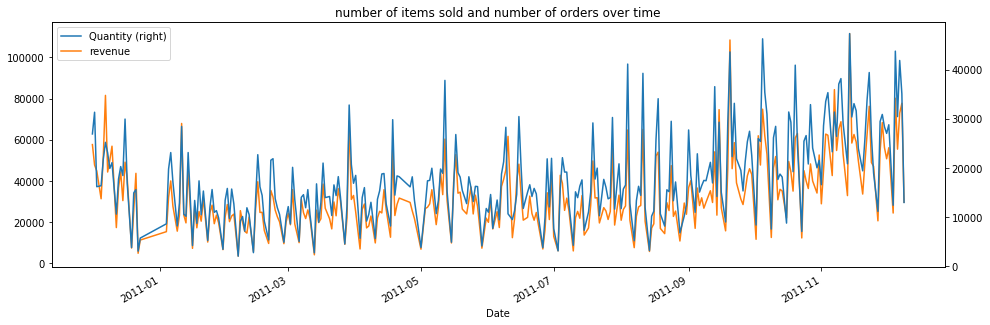

In [101]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)
df['Date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['revenue'] = df.Quantity * df.UnitPrice

df.groupby('Date').agg(
    {'Quantity': 'sum', 'revenue': 'sum'}
).plot(
    title='number of items sold and number of orders over time', 
    secondary_y='Quantity',
    figsize=(16, 5)
)

In [9]:
df = (
    df
    .assign(
        dNormalPrice=lambda d: d.UnitPrice 
            / d.groupby('StockCode').UnitPrice.transform('median') 
    )
    .pipe(
        lambda d: d[
            (d['dNormalPrice'] > 1./3) &
            (d['dNormalPrice'] < 3.)
        ]
    )
    .drop(columns=['dNormalPrice'])
)

In [10]:
df = df.groupby(['Date', 'StockCode', 'Country'], as_index=False).agg({
    'Description': 'first',
    'Quantity': 'sum', 
    'revenue': 'sum'
})
df['Description'] = df.groupby('StockCode').Description.transform('first')

df['UnitPrice'] = df['revenue'] / df['Quantity'] # implicit quantity-weighted avg of prices

In [11]:
df.to_parquet('ecom_sample_clean.parquet')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor


feature_generator = ColumnTransformer(
    [
        ('item_id', OneHotEncoder(), ['item_id']), 
        ('date', OneHotEncoder(), ['date']),
        ('item_description', 
             CountVectorizer(min_df=0.05, ngram_range=(1, 3)), 
             'item_description'),
        ('numeric_feats', StandardScaler(), 
             ['day_of_week', 'stock_age_in_days'])
    ], remainder='drop'
)

model_q = Pipeline([
    ('feat_proc', feature_generator),
    ('model_q', RandomForestRegressor()) 
])
model_p = Pipeline([
    ('feat_proc', feature_generator),
    ('model_p', RandomForestRegressor())
])

In [ ]:
from sklearn.model_selection import KFold

# Since Q might be 0, can't just take logs. This is a quick
# workaround for demonstration. Better options exist.
df_mdl['LnP'] = np.log1p(df_mdl['P'])
df_mdl['LnQ'] = np.log1p(df_mdl['Q'])
elast_estimates = list()

# Step 1: split into two halves
for idx_aux, idx_inf in KFold(
    n_splits=2, shuffle=True).split(df_mdl):
    
    df_aux = df_mdl.iloc[idx_aux]
    df_inf = df_mdl.iloc[idx_inf].copy()
    
    # Step 2+3: fit auxiliary models on first half
    model_q.fit(df_aux, df_aux['LnQ'])
    model_p.fit(df_aux, df_aux['LnP'])
    
    # Step 4: residualize in second half
    df_inf = df_inf.assign(
        LnP_res = df_inf['LnP'] - model_p.predict(df_inf),
        LnQ_res = df_inf['LnQ'] - model_q.predict(df_inf),
    )
    
   # Step 5: DML inference
    elast = (
        df_inf['LnP_res'].dot(df_inf['LnQ_res'])
        /
        df_inf['LnP_res'].dot(df_inf['LnP'])
        # the last part here deviates from standard OLS solution
    )
    
    print('DML elasticity:', elast)
    elast_estimates.append(elast)

    print('OLS elasticity for comparison:',
        df_inf['LnP_res'].dot(df_inf['LnQ_res'])
        /
        df_inf['LnP_res'].dot(df_inf['LnP_res'])
    )    

# Step 6: Take the mean of both estimates
print("DML efficient estimate of elasticity:", np.mean(elast_estimates))